# Segmentation of Scans

## Libraries

In [ ]:
from importlib import reload
from sklearn.model_selection import train_test_split
import os
import glob
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np


# Custom modules
import config
from core.unet import UNet
from core.unet_attention import AttU_Net
from core.dataset import SegmentationDataset
import utils.visualization as visualization

## Dataset Creation and Split

Define transformations to ensure fixed image size and data augumentation.

In [ ]:
# Define Transformation
custom_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=30),  # Random rotation within ±30 degrees
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),  # Random translation within 10% of the image dimensions
        shear=(-15, 15)  # Random shear (tilt) +-15 degrees
    ),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),    # Random vertical flip
    transforms.Resize(
        (config.IMG_HEIGHT, config.IMG_WIDTH),
        interpolation=InterpolationMode.NEAREST,
        antialias=False
    )
])

resize_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(
        (config.IMG_HEIGHT, config.IMG_WIDTH),
        interpolation=InterpolationMode.NEAREST,
        antialias=False
    )
])

Create the dataset using a custom dataset class "SegmentationDataset".

In [ ]:
# Create the Train and Test Datasets
train_dataset = SegmentationDataset(config.PTH_DATA, transform = custom_transform, train = True, test_size = .2, seed = 42)
test_dataset = SegmentationDataset(config.PTH_DATA, transform = resize_transform, train = False, test_size = .2, seed = 42) # resize only

In [ ]:
print(f'Train Set Size: {len(train_dataset)}')
print(f'Test Set Size: {len(test_dataset)}')

Train Set Size: 517
Test Set Size: 130


In [ ]:
print(f'Image, Mask shapes in Train: {train_dataset[43][0].shape}, {train_dataset[43][1].shape}')
print(f'Image, Mask shapes in Test: {test_dataset[43][0].shape}, {test_dataset[43][1].shape}')

Image, Mask shapes in Train: torch.Size([1, 64, 64]), torch.Size([1, 64, 64])
Image, Mask shapes in Test: torch.Size([1, 64, 64]), torch.Size([1, 64, 64])


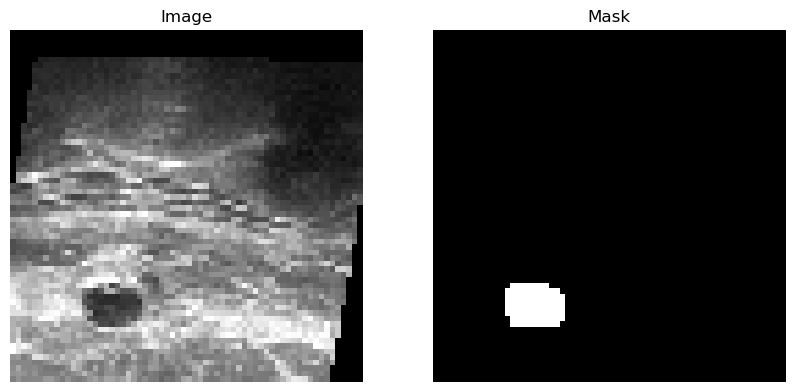

In [ ]:
visualization.plot_example(train_dataset[234])

## Data Loaders

In [ ]:
# Create the training and test data loaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=config.BATCH_SIZE)
test_loader = DataLoader(test_dataset,  shuffle=False, batch_size=config.BATCH_SIZE)
print(f'Batch Size : {train_loader.batch_size}')
num_train_batches = len(train_dataset) // train_loader.batch_size
num_test_batches = len(test_dataset) // test_loader.batch_size
print(f'Number Batches in Train: {num_train_batches}')
print(f'Number Batches in Test: {num_test_batches}')

Batch Size : 32
Number Batches in Train: 16
Number Batches in Test: 4


## Device

In [ ]:
device = torch.device(config.AVAILABLE_DEVICE)
print(f'using: {device}')

using: cuda


## Model

In [ ]:
model = AttU_Net(1,1).to(device)

In [ ]:
num_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of Learnable Parameters: {num_param}')

number of learnable parameters: 34877421


We test the model on the first image to check the shape of the output.

In [ ]:
# Random tensor
input_tensor = torch.randn(1, 1, config.IMG_HEIGHT, config.IMG_WIDTH).to(device)

model.eval()
with torch.no_grad():
    output = model(input_tensor)
print(output.shape)

torch.Size([1, 1, 64, 64])


## Loss, Optimzer, Learning Rate Scheduler

In [ ]:
# loss fn
loss_fn = nn.BCEWithLogitsLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, nesterov=True, weight_decay = 0.00001)

# scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=config.NUM_EPOCHS, eta_min=0.00001)

## Checkpoints

In [ ]:
# Save checkpoint
def save_checkpoint(epoch, model, optimizer, scheduler, train_loss_epoch_history, test_loss_epoch_history):
    # generate name using current time
    filepath = os.path.join(config.PTH_CHECKPOINTS, datetime.now().strftime('%Y-%m-%d_%H:%M:%S') + '_checkpoint.pt')
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss_epoch_history': train_loss_epoch_history,
        'test_loss_epoch_history': test_loss_epoch_history
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch+1}")

# Load checkpoint
def load_checkpoint(filepath, model, optimizer, scheduler):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']+1
    train_loss_epoch_history = checkpoint['train_loss_epoch_history']
    test_loss_epoch_history = checkpoint['test_loss_epoch_history']
    print(f"Checkpoint loaded from epoch {epoch}\n")
    return epoch, train_loss_epoch_history, test_loss_epoch_history

## Training and Evaluation Loop

In [ ]:
print(f'Number of Epochs: {config.NUM_EPOCHS}')

Number of epochs: 50


In [ ]:
# Define the cosine learning rate scheduler

train_loss_epoch_history = []
test_loss_epoch_history = []

# Checkpoint name
checkpoint_name = '2024-05-20_20:50:45_checkpoint.pt'  # Specify the checkpoint file name in saves/models
start_epoch = 0

# Load checkpoint if it exists
load_checkpoint = False
if load_checkpoint:
    checkpoint_path = os.path.join(config.PTH_SAVED_MODELS, checkpoint_name)
    start_epoch, train_loss_epoch_history, test_loss_epoch_history = load_checkpoint(checkpoint_path, model, optimizer, scheduler)
    print(start_epoch, train_loss_epoch_history,test_loss_epoch_history)
    # change optimizer params if needed here

# Training loop
for epoch in range(start_epoch, config.NUM_EPOCHS):
    # Print epoch start
    print(f'Starting epoch: {epoch+1}\n-----------\n')
    print(f'learning rate: {scheduler.get_last_lr()}\n')

    # Set the model to training mode
    model.train()

    # Current epoch loss
    running_loss = 0.0
    total_samples = 0

    for idx, (inputs, labels) in enumerate(train_loader):
        # Send to device
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = loss_fn(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize
        optimizer.step()

        # Retrieve batch loss
        batch_loss = loss.item()

        # Add it to running loss
        running_loss += batch_loss * batch_size
        total_samples += batch_size

        # Print batch loss every 10 batches
        if idx % 10 == 0:
            print(f'batch: {idx}/{len(train_loader)}\tbatch loss: {batch_loss}')

    # Calculate average training loss for the epoch
    train_loss = running_loss / total_samples  # Divide by the number of samples
    train_loss_epoch_history.append(train_loss)
    print(f"End of epoch {epoch+1}/{config.NUM_EPOCHS}\nTraining Loss: {train_loss}\n")

    # Step the scheduler
    scheduler.step()

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            batch_size = inputs.size(0)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * batch_size
            total_samples += batch_size

    # Calculate average validation loss for the epoch
    val_loss = running_loss / total_samples  # Divide by the number of samples
    test_loss_epoch_history.append(val_loss)
    print(f"Validation Loss: {val_loss}\n------------\n")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_checkpoint(epoch, model, optimizer, scheduler, train_loss_epoch_history, test_loss_epoch_history)


Starting epoch: 1
-----------

learning rate: [0.1]

batch: 0/17	batch loss: 0.6593648791313171
batch: 10/17	batch loss: 0.22146590054035187
End of epoch 1/50
Training Loss: 0.30614360599153506

Validation Loss: 0.24592315967266376
------------

Starting epoch: 2
-----------

learning rate: [0.09990134628777145]

batch: 0/17	batch loss: 0.21200475096702576
batch: 10/17	batch loss: 0.21077880263328552
End of epoch 2/50
Training Loss: 0.2167903890173947

Validation Loss: 0.26488140546358546
------------

Starting epoch: 3
-----------

learning rate: [0.09960577449221733]

batch: 0/17	batch loss: 0.16322708129882812
batch: 10/17	batch loss: 0.1325310915708542
End of epoch 3/50
Training Loss: 0.18960340914804655

Validation Loss: 0.37875624482448284
------------

Starting epoch: 4
-----------

learning rate: [0.0991144511001808]

batch: 0/17	batch loss: 0.21111425757408142
batch: 10/17	batch loss: 0.16094443202018738
End of epoch 4/50
Training Loss: 0.17334046129792988

Validation Loss: 0.

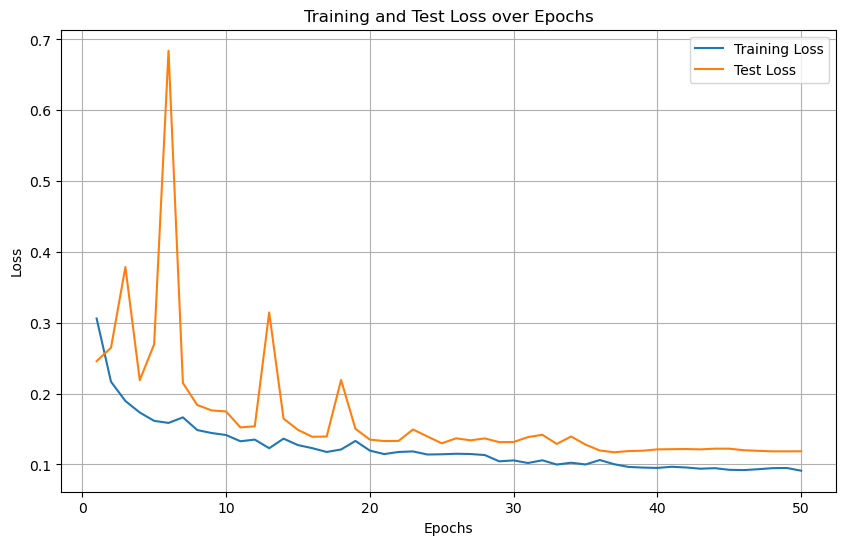

In [ ]:
epochs = range(1, len(train_loss_epoch_history) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_epoch_history, label='Training Loss')
plt.plot(epochs, test_loss_epoch_history, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig(config.PTH_SAVED_FIGURES+'/training_test_loss_over_epochs_unet_with_att.png')
plt.show()

# Test Results

Training Set

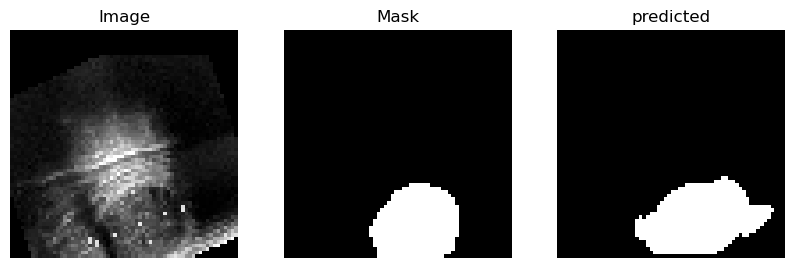

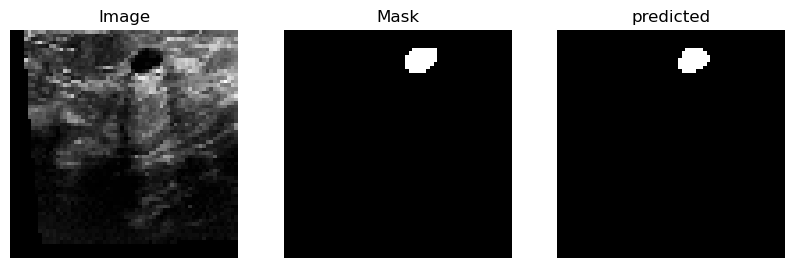

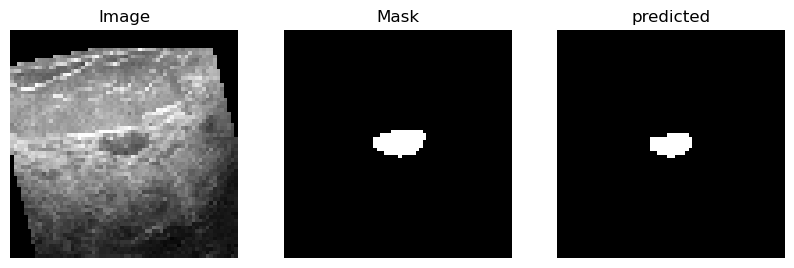

In [ ]:
model.eval()
for idx in range(0, 3):
    with torch.no_grad():
        # Prepare input and label
        example = train_dataset[idx]
        input, label = example
        input = input.unsqueeze(0)
        input = input.to(device)
        label = label.to(device)

        # Get logits from the model
        logits = model(input)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)

        # Convert probabilities to binary predictions (0 or 1)
        pred_mask = (probs > 0.5).cpu().numpy().astype(int)

        # Plot the prediction
        visualization.plot_prediction(example, pred_mask)

Find the best threshold for prediction using IoU.

In [ ]:
def average_iou(threshold):
    print('Using Threshold:', threshold)
    def IoU(img1,img2):
        img1 = img1.cpu().numpy()
        #img2 = img2.cpu().numpy()

        # Calculate intersection and union using bitwise operations
        inter = np.logical_and(img1, img2).sum()
        union = np.logical_or(img1, img2).sum()

        # Calculate IoU
        iou_value = inter / union if union != 0 else 0

        return iou_value

    total_iou = 0

    model.eval()
    for idx in range(len(train_dataset)):
        with torch.no_grad():
            # Prepare input and label
            example = train_dataset[idx]
            input, label = example
            input = input.unsqueeze(0)
            input = input.to(device)
            label = label.to(device)

            # Get logits from the model
            logits = model(input)

            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(logits)

            # Convert probabilities to binary predictions (0 or 1)
            pred_mask = (probs >= threshold ).cpu().numpy().astype(int)

            iou = IoU(label, pred_mask)

            total_iou += iou

    return total_iou / len(train_dataset)

In [ ]:
thresholds = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
iou_vs_threshold = [average_iou(thr) for thr in thresholds]

using threshold: 0.1
using threshold: 0.2
using threshold: 0.3
using threshold: 0.4
using threshold: 0.5
using threshold: 0.6
using threshold: 0.7
using threshold: 0.8
using threshold: 0.9


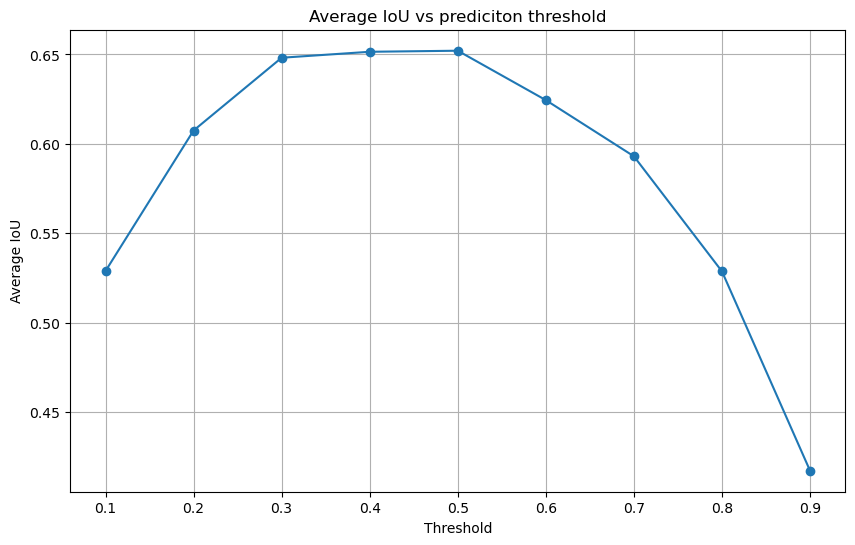

In [ ]:
# Plotting the IoU vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, iou_vs_threshold, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Average IoU')
plt.title('Average IoU vs. Prediciton Threshold')
plt.grid(True)
plt.savefig(config.PTH_SAVED_FIGURES+'/iou_thr_plot_train_2.png')
plt.show()

A threshold of 0.5 achieves the best IoU.

In [ ]:
best_model = config.PTH_SAVED_MODELS + '/2024-05-24_15:35:01_model.pth'
segmentation_model = torch.load(best_model).to(device)

<Figure size 640x480 with 0 Axes>

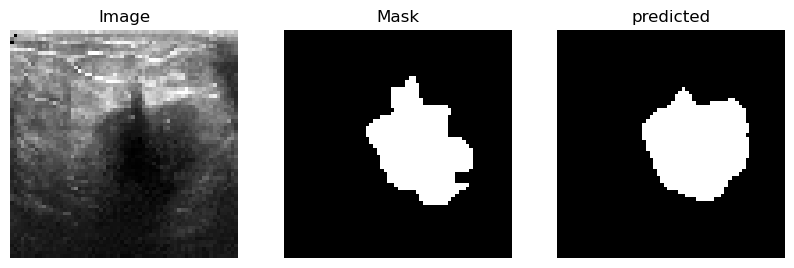

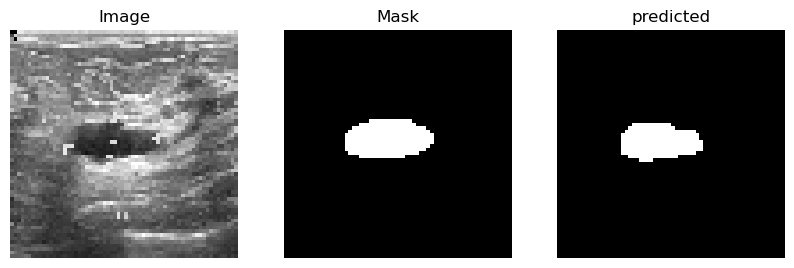

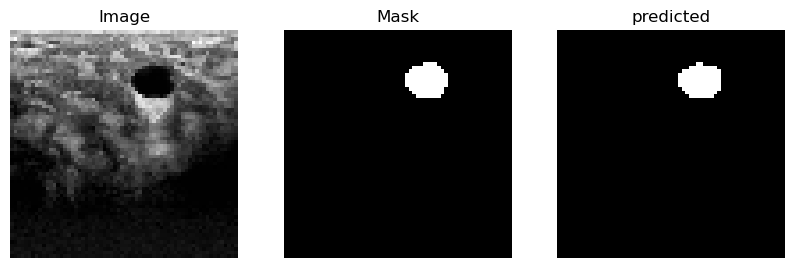

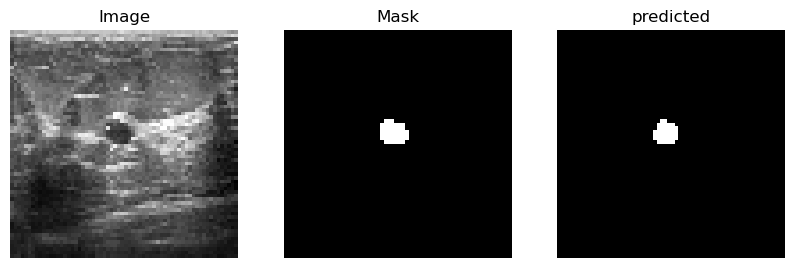

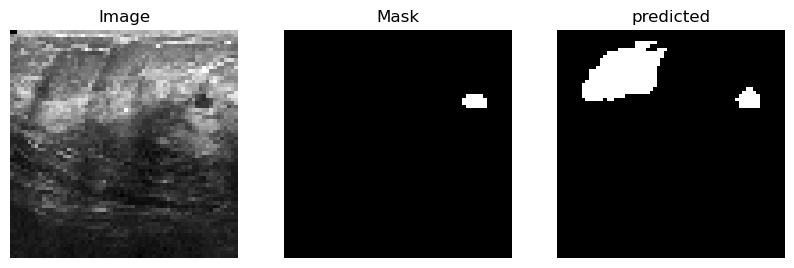

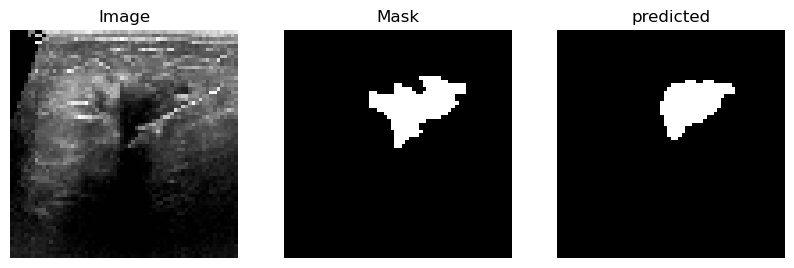

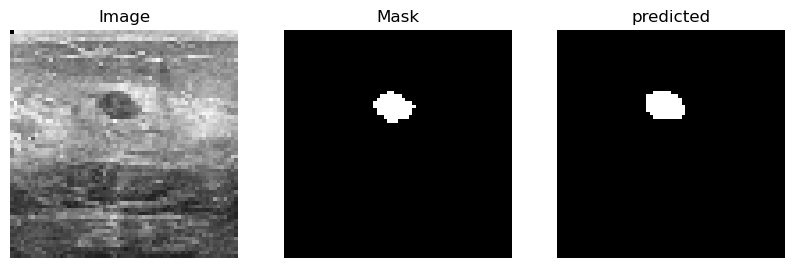

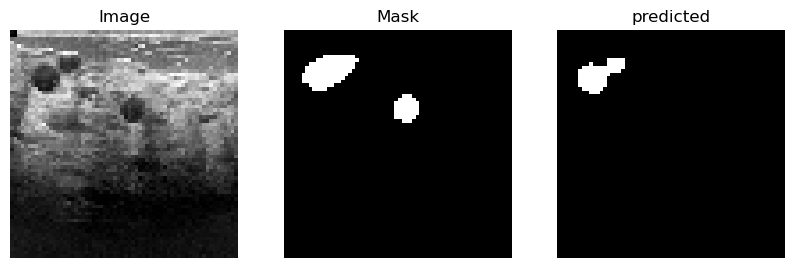

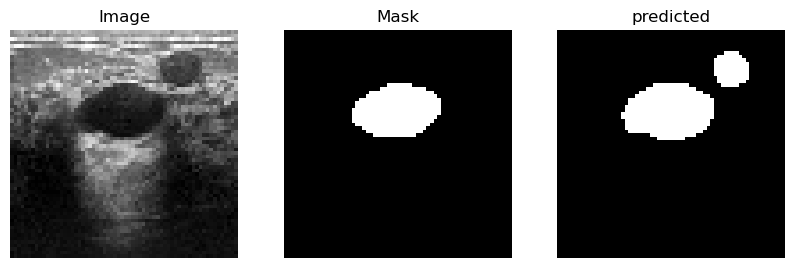

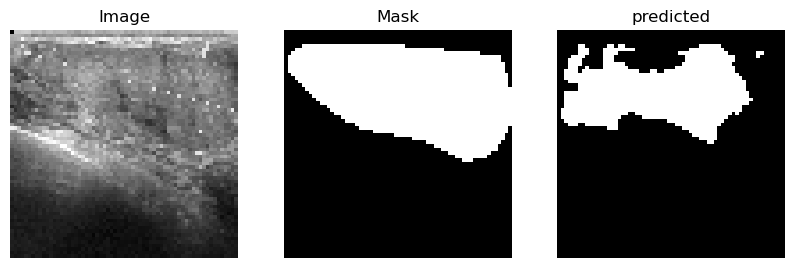

In [ ]:
segmentation_model.eval()
for idx in range(0, 10):
    with torch.no_grad():
        # Prepare input and label
        example = test_dataset[idx]
        input, label = example
        input = input.unsqueeze(0)
        input = input.to(device)
        label = label.to(device)

        # Get logits from the model
        logits = segmentation_model(input)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)

        # Convert probabilities to binary predictions (0 or 1)
        pred_mask = (probs >= 0.5).cpu().numpy().astype(int)

        # Plot the prediction
        plt.savefig(config.PTH_SAVED_FIGURES+'/test_with_pred_'+str(idx)+'_.png')
        visualization.plot_prediction(example, pred_mask)

# Save the Model

In [ ]:
model_pth_name = os.path.join(config.PTH_SAVED_MODELS, datetime.now().strftime('%Y-%m-%d_%H:%M:%S') + '_model.pth')
torch.save(model, model_pth_name)

# List of Paths to Good Models
- /home/default/gdrive/ML-Project/saves/models/2024-05-22_16:54:28_model.pth
- /home/default/gdrive/ML-Project/saves/models/2024-05-24_14:54:45_model.pth

